# GMMによる異常値の予測

## 1.はじめに

本ノートブックでは、混合ガウスモデルを使って異常値の予測を行います。

アルゴリズムとしては、GMMを用います。

## 2.事前準備
### ①scikit-learnのGaussianMixtureを使ってフィッティングと予測のためのクラスの準備

GaussianMixtureをそのまま使うとオプションにてクラスタ数を自分で定める必要があり、最適なクラスタ数かどうか分かりません。そこで、BICが最小になるようにクラスタ数を探索するGMMAnomalyDetectorというクラスを作成します。

### ②numpyによる標準正規分布を用いた正常値データの生成と異常値データの生成

データを自作します。numpyによる乱数を用いて正常値データと異常値データを生成していきます。

## 3.コードの作成
まずは①のクラスの準備から行っていきます。

In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture

class GMMAnomalyDetector:
    def __init__(self, max_n_component, covariance_type='full'):
        self._max_n_component = max_n_component
        self._covariance_type = covariance_type
        self._best_gmm = None
        self.best_n_component = -1

    def fit(self, X):
        # BICを最小にするベストなクラスタ数を2～max_n_componentの範囲で探索
        lowest_bic = np.inf
        for n_component in range(2, self._max_n_component + 1):
            gmm = GaussianMixture(n_components=n_component, covariance_type=self._covariance_type)
            gmm.fit(X)
            bic = gmm.bic(X)
            if bic < lowest_bic:
                lowest_bic = bic
                self._best_gmm = gmm
                self.best_n_component = n_component

    def predict(self, X, contamination=0.1):
        # スコア下位N%を異常と見なす
        scores = np.exp(self._best_gmm.score_samples(X))
        ordered_scores = np.argsort(scores)
        anomaly_indices = ordered_scores[:int(len(scores)*contamination + 0.5)]
        
        # scikit-learnに倣って正常を1、異常を-1として返す
        prediction = np.ones((len(scores)), dtype=np.int)
        prediction[anomaly_indices] = -1
        return prediction

## 4.トレーニングデータ、異常値データの生成と予測とグラフの描画

次に②の部分です。作成したGMMAnomalyDetectorクラスとnumpyの乱数によるトレーニングデータの生成と異常値データの生成を行いフィッティングと予測、グラフの描画を行います。

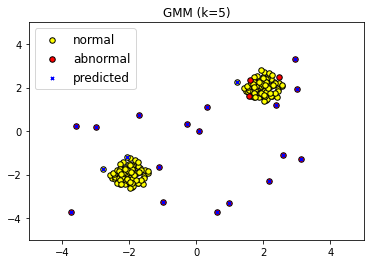

In [24]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# trainデータの生成 標準正規分布
X_ = 0.3 * np.random.randn(100, 2)

# 異常値の生成
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.vstack([X_ + 2, X_ - 2, X_outliers])

# モデルのフィッティング
clf = GMMAnomalyDetector(max_n_component=8)
clf.fit(X)

# 全体の9%が異常データ
contamination = 0.09

y_pred = clf.predict(X, contamination)

# 正常を1、異常を-1と出力

predicted_outlier_index = np.where(y_pred == -1)
predicted_outlier = X[predicted_outlier_index]

plt.title("GMM (k=" + str(clf.best_n_component) + ')')

a = plt.scatter(X[:200, 0], X[:200, 1], c='yellow',
                edgecolor='k', s=30, marker='o')
b = plt.scatter(X[200:, 0], X[200:, 1], c='red',
                edgecolor='k', s=30, marker='o')
c = plt.scatter(predicted_outlier[:, 0], predicted_outlier[:, 1], c='blue',
                edgecolor='k', s=10, marker='x')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b, c],
           ["normal",
            "abnormal",
            "predicted"],
           loc="upper left", prop={'size': 12})
plt.show()